# 3D spring example

### Preamble

- Include the necesary modules from Julia's standard repositories.
- Here we run on 16 cores for parallel evaluation of the elements contribution to free energy, thus we need to import the Distributed module

In [1]:
using Distributed
using Statistics, LinearAlgebra
using Printf, WriteVTK, AbaqusReader
using PyCall, PyPlot, JLD, ProgressMeter

In [2]:
@everywhere include("adiff.jl")
@everywhere include("materials.jl")
@everywhere include("elements.jl")
;

this makes sure that the loop over the elements is split between 16 independent thread

In [3]:
@show Elements.setp(16)
;

Elements.setp(16) = 16


In [4]:
sMeshFile = "3DSpringFineMesh.inp"
mat       = Materials.NeoHooke(10)
bisinc    = true
sVTKpath  = "./vtk_files/"
dTol      = 1e-8
bVTKall   = true
;

In [5]:
Δz        = 500
sPosFix   = "NH_beta"
N         = 50
LF        = range(0, 1.0, length=N)
;

In [6]:
sFileName = splitext(sMeshFile)[1]*sPosFix
mymodel   = AbaqusReader.abaqus_read_mesh(sMeshFile)
nodes     = [mymodel["nodes"][ii] for ii in 1:mymodel["nodes"].count]
el_nodes  = [item[2]              for item in mymodel["elements"]] 
id_b      = mymodel["node_sets"]["BTM"]
id_t      = mymodel["node_sets"]["TOP"]
;

┌ Info: 5086 nodes found
└ @ AbaqusReader /u1/vian294/.julia/packages/AbaqusReader/SDhGN/src/parse_mesh.jl:109
┌ Info: Parsing elements. Type: C3D4. Topology: Tet4
└ @ AbaqusReader /u1/vian294/.julia/packages/AbaqusReader/SDhGN/src/parse_mesh.jl:153
┌ Info: Adding elset: Evolumes
└ @ AbaqusReader /u1/vian294/.julia/packages/AbaqusReader/SDhGN/src/parse_mesh.jl:88
┌ Info: Creating elset Eall
└ @ AbaqusReader /u1/vian294/.julia/packages/AbaqusReader/SDhGN/src/parse_mesh.jl:187
┌ Info: Creating elset SolidMaterial002Solid
└ @ AbaqusReader /u1/vian294/.julia/packages/AbaqusReader/SDhGN/src/parse_mesh.jl:187
┌ Info: Creating nset BTM
└ @ AbaqusReader /u1/vian294/.julia/packages/AbaqusReader/SDhGN/src/parse_mesh.jl:187
┌ Info: Creating nset TOP
└ @ AbaqusReader /u1/vian294/.julia/packages/AbaqusReader/SDhGN/src/parse_mesh.jl:187


In [7]:
points    = hcat(nodes...)
cells     = [ MeshCell(VTKCellTypes.VTK_TETRA, nodes)
    for nodes in el_nodes]
elems     = [ Elements.Tet04(item[2], nodes[item[2]], mat=mat)
    for item in  mymodel["elements"] ]
n_t, n_b = length(id_t), length(id_b)
@show nNodes, nElems   = length(nodes), length(el_nodes)
;

(nNodes, nElems) = (length(nodes), length(el_nodes)) = (5086, 18871)


In [8]:
idxx  = LinearIndices((3,nNodes))
eqns0 = vcat([Elements.ConstEq(x-> begin
                                 J = Elements.getJ(Elements.getF(elem, x)) 
                                 elem.V*(J-1)
                               end, idxx[:,elem.nodes][:])
              for elem in elems]...)
;

using LinearAlgebra, Printf, SparseArrays, IterativeSolvers
using PyPlot, PyCall, ProgressMeter, Dates, StatsBase
using Distributed

using ..adiff, ..Materials
import ..Materials.getϕ


In [9]:
using ProgressMeter, SparseArrays, Dates
# import ..Materials.getϕ

# using IterativeSolvers

In [28]:
# solver 
function solvestep!(elems, u, bfreeu;
                    fe        = zeros(length(u)),
                    eqns      = [],
                    λ         = zeros(length(eqns)),
                    dTol      = 1e-6,
                    dTolu     = dTol,
                    dTole     = dTol,
                    dTolupdt  = dTol,
                    dNoise    = 1e-12,
                    maxiter   = 6,
                    becho     = false,
                    bprogress = false)

  if bprogress
    p = ProgressMeter.ProgressThresh(dTol)
  end


  ifreeu    = findall(bfreeu[:])
  icnstu    = findall(.!bfreeu[:])

  nEqs      = length(eqns)
  nfreeu    = length(ifreeu)
  ncnstu    = length(icnstu)
  nDoFs     = nfreeu + nEqs
  ncDoFs    = ncnstu + nEqs
  iius      = 1:nfreeu
  iieqs     = nfreeu .+ (1:nEqs)

  bdone     = false
  bfailed   = false
  iter      = 0

  if nEqs !=0
    Ntot = nfreeu+nEqs
    H    = spzeros(Ntot, Ntot)
    updt = zeros(Ntot)
  end

  normupdt = NaN
  becho && println() 
  while !bdone & !bfailed 
    global normr
    tic = Base.time_ns()
    (Φ, fi, Kt) = Elements.getϕ(elems, u)
    if nEqs == 0
      res   = fi[ifreeu]-fe[ifreeu]
      norm0 = norm(fi[icnstu])/ncnstu
    else
      (vEqs,rEqs,KEqs) = Elements.getϕ(eqns, u, λ)
      resu  = fi[ifreeu]-fe[ifreeu]-rEqs[ifreeu,:]*λ
      rese  = -vEqs
      res   = vcat(resu, rese)
      norm0 = ncnstu>0 ? maximum(abs.(fi[icnstu])) : 0.0
    end

    # normresu = maximum(abs.(resu))/dTolu
    # normrese = maximum(abs.(rese))/dTole
    normresu = norm(resu)/nfreeu/dTolu
    normrese = norm(rese)/nEqs/dTole
    normr    = max(normresu,normrese)
    if (normr<1) | (normupdt<dTolupdt)
      bdone   = true
      fe[:]   = nEqs==0 ? fi[:] : fi[:]-rEqs*λ
    elseif iter < maxiter
      if nEqs == 0
        updt      = Kt[ifreeu,ifreeu]\res
        u[ifreeu] .-= updt
      else
        H[iius,iius]   = Kt[ifreeu,ifreeu]-KEqs[ifreeu,ifreeu]
        H[iius,iieqs]  = -rEqs[ifreeu,:]
        H[iieqs,iius]  = transpose(H[iius,iieqs])
        H[iieqs,iieqs] = spdiagm(0=>dNoise*randn(nEqs))
        # updt           = H\res
        updt          = qr(H)\res
        # updt          = lu(H)\res
        # minres!(updt,H,res)
        u[ifreeu]     .-= updt[iius]
        λ             .-= updt[iieqs]
        normupdt = maximum(abs.(updt))
      end              
    else
      bfailed = true
    end    
    iter  += 1
    bprogress && ProgressMeter.update!(p, normr)
    becho && @printf("iter: %2i, normresu: %.2e, normrese: %.2e, normr: %.2e, normupdt: %.2e, eltime: %.2f sec. \n", 
              iter, normresu, normrese, normr, 
              normupdt, Int64(Base.time_ns()-tic)/1e9)
    becho && flush(stdout)
  end

  (bfailed, normr, iter)
end
;

In [30]:
ifree  = trues(3, nNodes)  
unew  = zeros(3, nNodes)
λnew  = zeros(length(eqns0)+6)
idxes  = LinearIndices(unew)
fnew   = zeros(3, nNodes)
allus  = []
N      = 100
LF     = range(0, 1.0, length=N)
;

In [34]:
ii   = 2
w0   = LF[ii]*Δz 

@printf("doing step %3i, LF = %.3f, w0 = %.3f", ii, LF[ii], w0); flush(stdout)
eqns = vcat(eqns0,
            Elements.ConstEq(x->sum(x),          idxes[1,id_t][:], adiff.D1),
            Elements.ConstEq(x->sum(x),          idxes[2,id_t][:], adiff.D1),
            Elements.ConstEq(x->sum(x)/n_t+w0/2, idxes[3,id_t][:], adiff.D1),
            Elements.ConstEq(x->sum(x),          idxes[1,id_b][:], adiff.D1),
            Elements.ConstEq(x->sum(x),          idxes[2,id_b][:], adiff.D1),
            Elements.ConstEq(x->sum(x)/n_b-w0/2, idxes[3,id_b][:], adiff.D1)) 
T     = @elapsed (bfailed, normr, iter) = 
    solvestep!(elems, unew, ifree, 
                eqns      = eqns,
                λ         = λnew,
                dTolu     = 1e-7,
                dTole     = 1e-3,
                dNoise    = 0,
                maxiter   = 5,
                bprogress = false,
                becho     = true)
if bfailed 
  @printf("\n!! failed at LF: %.3f, with normr/dTol: %.3e\n", LF[ii], normr/dTol)
else
  lastu = copy(unew)
  lastλ = copy(λnew)
  @printf("step %2i done in %2i iter, after %.2f sec.\n\n", ii, iter, T)
end


doing step   2, LF = 0.010, w0 = 5.051
iter:  1, normresu: 0.00e+00, normrese: 1.89e-01, normr: 1.89e-01, normupdt: NaN, eltime: 18.73 sec. 
step  2 done in  1 iter, after 18.73 sec.



In [39]:
ifreeu    = findall(ifree[:])

@time (Φ, fi, Kt) = Elements.getϕ(elems, unew)
@time (vEqs,rEqs,KEqs) = Elements.getϕ(eqns, unew, λnew)

In [41]:
resu  = fi[ifreeu]-fnew[ifreeu]-rEqs[ifreeu,:]*λnew
rese  = -vEqs
res   = vcat(resu, rese)

;

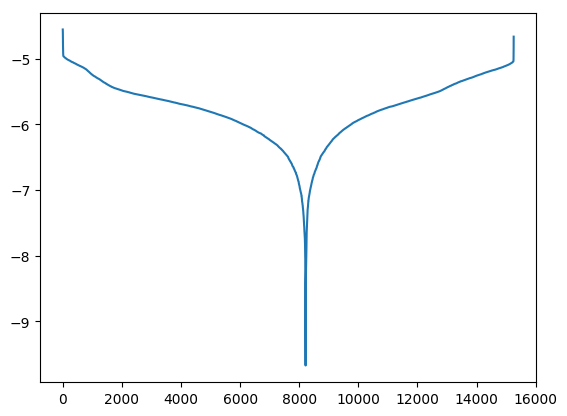

In [36]:
PyPlot.plot(log10.(abs.(sort(fnew[:]))))
;

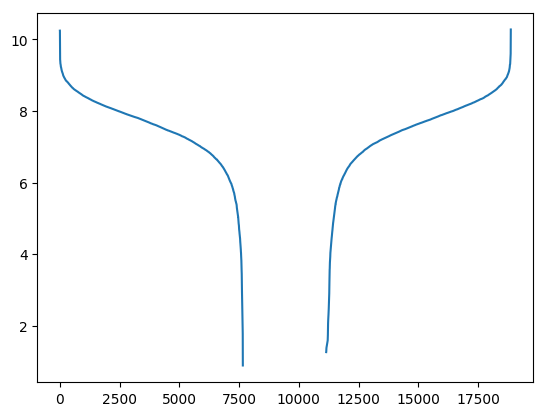

In [55]:
PyPlot.plot(log10.(abs.(sort(λnew[1:end-6]))))
;

In [49]:
ifree = trues(3, nNodes)  
unew  = zeros(3, nNodes)
λnew  = zeros(length(eqns0)+6)
idxes = LinearIndices(unew)
fnew  = zeros(3, nNodes)
allus = []
N     = 100
dTol  = 1e-5

LF    = range(0, 1.0, length=100)

t0    = Base.time_ns()
for (ii,LF) in enumerate(LF)
    w0  = LF*Δz 
    @printf("doing step %3i, LF = %.3f, w0 = %.3f", ii, LF, w0); flush(stdout)

    eqns = vcat(eqns0,
                Elements.ConstEq(x->sum(x),          idxes[1,id_t][:], adiff.D1),
                Elements.ConstEq(x->sum(x),          idxes[2,id_t][:], adiff.D1),
                Elements.ConstEq(x->sum(x)/n_t+w0/2, idxes[3,id_t][:], adiff.D1),
                Elements.ConstEq(x->sum(x),          idxes[1,id_b][:], adiff.D1),
                Elements.ConstEq(x->sum(x),          idxes[2,id_b][:], adiff.D1),
                Elements.ConstEq(x->sum(x)/n_b-w0/2, idxes[3,id_b][:], adiff.D1)) 

    lastu = copy(unew)
    lastλ = copy(λnew)
    fnew  = zeros(3, nNodes)
    T     = @elapsed (bfailed, normr, iter) = 
        solvestep!(elems, unew, ifree, 
                    eqns      = eqns,
                    λ         = λnew,
                    fe        = fnew, 
                    dTolu     = 1e-5,
                    dTole     = 1e-3,
                    dTolupdt  = 1e-2,
                    dNoise    = 0,
                    maxiter   = 21,
                    bprogress = false,
                    becho     = true)
    if bfailed 
      @printf("!! failed at LF: %.3f, with normr/dTol: %.3e\n\n", LF, normr/dTol)
      unew = lastu
      λnew = lastλ
      break
    else
      push!(allus, (copy(unew), copy(fnew), copy(λnew)))
      @printf("step %2i done in %2i iter, after %.2f sec.\n\n", ii, iter, T)
    end
end
@printf("completed in %s\n",(Base.time_ns()-t0)÷1e9|>Dates.Second|>Dates.CompoundPeriod|>
        Dates.canonicalize)

doing step   1, LF = 0.000, w0 = 0.000
iter:  1, normresu: 2.60e+04, normrese: 0.00e+00, normr: 2.60e+04, normupdt: 1.90e+10, eltime: 11.79 sec. 
iter:  2, normresu: 1.92e+05, normrese: 4.22e-07, normr: 1.92e+05, normupdt: 1.91e-04, eltime: 14.43 sec. 
iter:  3, normresu: 5.69e-01, normrese: 1.33e-05, normr: 5.69e-01, normupdt: 1.91e-04, eltime: 11.00 sec. 
step  1 done in  3 iter, after 37.22 sec.

doing step   2, LF = 0.010, w0 = 5.051
iter:  1, normresu: 5.69e-01, normrese: 1.89e-01, normr: 5.69e-01, normupdt: NaN, eltime: 10.97 sec. 
step  2 done in  1 iter, after 10.97 sec.

doing step   3, LF = 0.020, w0 = 10.101
iter:  1, normresu: 5.69e-01, normrese: 3.78e-01, normr: 5.69e-01, normupdt: NaN, eltime: 11.09 sec. 
step  3 done in  1 iter, after 11.09 sec.

doing step   4, LF = 0.030, w0 = 15.152
iter:  1, normresu: 5.69e-01, normrese: 5.68e-01, normr: 5.69e-01, normupdt: NaN, eltime: 11.00 sec. 
step  4 done in  1 iter, after 11.00 sec.

doing step   5, LF = 0.040, w0 = 20.202
ite

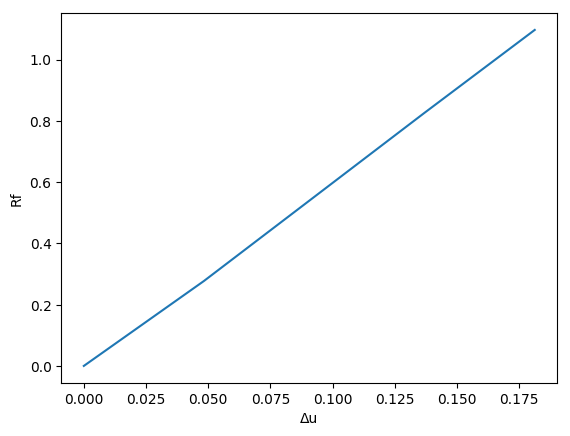

In [48]:
  rf_tot = [sum(item[2][3, id_b])   for item in allus]
  Δu_tot = [mean(item[1][3, id_b])  for item in allus]

PyPlot.plot(Δu_tot, rf_tot)
PyPlot.ylabel("Rf")
PyPlot.xlabel("Δu")
;

In [12]:
  JLD.save(sFileName*".jld", "nodes", nodes, "elems", elems, "allus", allus,
           "points", points, "cells", cells, "LF", LF, "mat", mat, 
           "Nsteps", length(LF), "id_b", id_b, "id_t", id_t, 
           "rf_tot", rf_tot, "Δu_tot", Δu_tot, "sFileName", sFileName)
  @printf("results written to %s\n", sFileName)

results written to 3DSpringFineMeshNH_beta


In [29]:
#
p = ProgressMeter.Progress(length(allus), desc="saving to "*sFileName*".pvd - ")
paraview_collection(sVTKpath*sFileName) do pvd
  for (ii, item) in enumerate(allus)
    (u0,rf) = item[1:2]
    F   = Elements.getinfo(elems,u0,info=:F)
    LE  = Elements.getinfo(elems,u0,info=:LE)
    J   = [det(F) for F in F]
    E   = [0.5*(transpose(F)*F-I) for F in F]
    σ   = [Materials.getinfo(F,mat,info=:σ)        for F in F]  # Cauchy stress
    S   = [Materials.getinfo(F,mat,info=:S)        for F in F]  # 2nd PK
    Ii  = [Materials.getInvariants(transpose(F)F)  for F in F]  # 2nd PK
    σP  = [sort(eigvals(σ))  for σ  in σ]
    σVM = [sqrt((x[1]-x[2])^2+(x[2]-x[3])^2+(x[3]-x[1])^2)/sqrt(2)  for x in σP]

    vtkobj  = vtk_grid(@sprintf("%s_%03i", sVTKpath*sFileName, ii), points+u0, cells)
    vtk_point_data(vtkobj, (u0[1,:],u0[2,:],u0[3,:]),                   "u")
    vtk_point_data(vtkobj, (rf[1,:],rf[2,:],rf[3,:]),                   "rf")
    vtk_cell_data(vtkobj,  tuple([getindex.(F,ii)  for ii in 1:9]...),  "F")
    vtk_cell_data(vtkobj,  tuple([getindex.(LE,ii)  for ii in 1:9]...), "LE")
    vtk_cell_data(vtkobj,  J,   "J")
    vtk_cell_data(vtkobj,  tuple([getindex.(σ,ii)   for ii in 1:9]...), "\$\\sigma\$")
    vtk_cell_data(vtkobj,  tuple([getindex.(σP,ii)  for ii in 1:3]...), "\$\\sigma_p\$")
    vtk_cell_data(vtkobj,  tuple([getindex.(Ii,ii)  for ii in 1:3]...), "I")
    vtk_cell_data(vtkobj,  σVM, "\$\\sigma_{VM}\$")

    collection_add_timestep(pvd, vtkobj, ii)
    vtk_save(vtkobj)
    ProgressMeter.next!(p)        
  end
end  


saving to 3DSpringFineMeshNH_beta.pvd - 100%|███████████| Time: 0:00:15


6-element Array{String,1}:
 "./vtk_files/3DSpringFineMeshNH_beta.pvd"    
 "./vtk_files/3DSpringFineMeshNH_beta_001.vtu"
 "./vtk_files/3DSpringFineMeshNH_beta_002.vtu"
 "./vtk_files/3DSpringFineMeshNH_beta_003.vtu"
 "./vtk_files/3DSpringFineMeshNH_beta_004.vtu"
 "./vtk_files/3DSpringFineMeshNH_beta_005.vtu"